In [1]:
import sys
import os

sys.path.append('scripts')

import json
import sys
import argparse
import itertools
from pathlib import Path
import collections
from concurrent.futures import ProcessPoolExecutor
import matplotlib.font_manager as fm

import numpy as np
from matplotlib.patches import FancyBboxPatch
from matplotlib.patches import PathPatch
from matplotlib.path import get_path_collection_extents
import matplotlib.pyplot as plt
import seaborn as sns

from rich import print, pretty
from typing import  Iterable
import pretty_errors
from catppuccin import PALETTE

pretty.install()

RESULTS_DIR = Path('./experiments/junction')
assert RESULTS_DIR.is_dir() and RESULTS_DIR.exists()

flavor = PALETTE.latte.colors



In [2]:
# use LaTeX for text with matplotlib
sns.set_style("darkgrid")
# set background color of sns darkgrid to flavor.base.hex
plt.rcParams['axes.facecolor'] = flavor.base.hex
# set font color to flavor.text.hex
plt.rcParams['text.color'] = flavor.text.hex

font_dirs = ["./scripts/fonts/"]
# go through all fonts in the font directory and add them
for font_dir in font_dirs:
    for font in os.listdir(font_dir):
        fm.fontManager.addfont(f"{font_dir}/{font}")

prop_jbm = fm.FontProperties(fname='./scripts/fonts/JetBrainsMonoNerdFontMono-Regular.ttf')
prop = fm.FontProperties(fname='./scripts/fonts/STIXTwoText-VariableFont_wght.ttf')

plt.rcParams.update({
    # "text.usetex": True,
    "font.family": prop.get_name(),
    # "font.family": "stix",
    # "font.sans-serif": prop.get_name(),
    "mathtext.fontset": "stix",
    # "text.latex.preamble": r"\usepackage{fontenc}\usepackage{fontspec}\setmainfont{JetBrainsMonoNerdFontMono-Regular}",
})

print(prop.get_name())

colors = [(flavor.lavender.hex, 1.0), (flavor.yellow.hex, 0.3), (flavor.peach.hex, 0.3)]

STIX Two Text

In [3]:

def flatten(lst: Iterable) -> list:
    return list(itertools.chain.from_iterable(lst))

def extract_data_from_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    # Assuming the JSON structure and extracting necessary information
    # Replace 'key' with actual key names in your JSON files

    durations: list[float] = []
    bins: list[int] = []


    goal_areas: list = [v for _, v in data['goal_areas'].items()]
    # print(f"{goal_areas=}")

    makespan = data['makespan']
    num_of_robots_reached_goal: int = sum((len(goal_area['history']) for goal_area in goal_areas))
    num_robots: int = len(data['robots'])
    # print(f"{num_of_robots_reached_goal=}, {num_robots=} {makespan=}")

    robot_ids: set[str] = set(data['robots'].keys())
    robots_not_reached_goal: set[str] = robot_ids - set(flatten((goal_area['history'].keys() for goal_area in goal_areas)))
    # print(f"{robots_not_reached_goal=}")

    # print the start time of the robots not reached goal
    # for entity, robot_data in data['robots'].items():
    #     if entity in robots_not_reached_goal:
    #         print(f"{entity=} {robot_data['mission']['started_at']=}")


    # start_at: float = 6.7
    ignore_after: float = 50.0
    num_robots_reached_goal: int = 0
    num_robots_after_ten_secs: int = 0
    for entity, robot_data in data['robots'].items():
        started_at: float = robot_data['mission']['started_at']
        if started_at >= ignore_after:
        # if started_at <= start_at:
            continue

        reached_goal: bool = False
        for goal_area in goal_areas:
            # print(f"{goal_area=}")
            for key, reached_at in goal_area['history'].items():
                if entity == key:
                    reached_goal = True
                    break

        if not reached_goal:
            continue

        num_robots_reached_goal += 1
        num_robots_after_ten_secs += 1

    # print(f"{num_robots=} {num_robots_reached_goal=} {num_robots_after_ten_secs=}")


    # t: float = makespan -  start_at
    t: float = ignore_after
    return (1 / (t / num_robots_reached_goal))


    num_robo

def process_file(file):
    qin_value = float(file.stem.split('-')[1])
    extracted_value = extract_data_from_file(file)
    return qin_value, extracted_value

[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
[0.0, 0.508, 1.0, 1.5199999999999998, 2.0, 2.5, 3.0, 3.5, 3.9760000000000004, 4.476, 4.948, 5.452, 5.964, 
6.408000000000001, 6.555999999999999]

/tmp/ipykernel_66642/1183339029.py:72: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


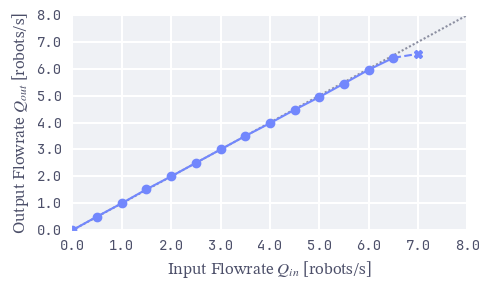

In [5]:
aggregated_data = collections.defaultdict(list)

with ProcessPoolExecutor() as executor:
    results = executor.map(process_file, RESULTS_DIR.glob('qin-*.json'))

# Aggregate results in a single-threaded manner to avoid data races
for Qin, extracted_value in results:
    aggregated_data[Qin].append(extracted_value)

xs: list[float] = []
ys: list[float] = []
for Qin, values in sorted(aggregated_data.items(), key=lambda x: x[0]):
    avg = sum(values) / len(values)
    ys.append(avg)
    xs.append(Qin)
    # print(f"{Qin=} {avg=}")

xs.insert(0, 0.)
ys.insert(0, 0.)

# plt.plot(xs, xs, color=flavor.red.hex)
# plt.plot(range(0, 8), range(0, 8), linestyle='--', dashes=(10, 5), color=flavor.overlay2.hex, legend='Ideal')
# plt.plot([0., 7.], [0., 7.], linestyle='--', dashes=(10, 5), color=flavor.overlay2.hex, label='Ideal')
fig, ax = plt.subplots(figsize=(5, 3))

x_max, y_max = (8., 8.)
ax.plot([0., x_max], [0., y_max], dashes=(1, 1), color=flavor.overlay1.hex, label="$Q_{in} = Q_{out}$")
ax.plot(xs[:-1], ys[:-1], marker='o', color=flavor.lavender.hex, label='Average flowrate over $50s$')

# plots the extra diverging point
ax.plot(xs[-2:], ys[-2:], marker=None, linestyle='--', color=flavor.lavender.hex)
# above puts a marker on both points, where I only want it on the last point
ax.plot(xs[-1], ys[-1], marker='X', linestyle='--', color=flavor.lavender.hex)

print(f"{xs}\n{ys}")

ax.set_xlabel(r'Input Flowrate $Q_{in}$ [robots/s]', fontsize=12, fontdict={'color': flavor.text.hex})
ax.set_ylabel(r'Output Flowrate $Q_{out}$ [robots/s]', fontsize=12, fontdict={'color': flavor.text.hex})
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_ylim(-0.02, 7.04)
ax.set_xlim(-0.02, 7.04)

x_ticks = np.arange(0, x_max + 0.5, 1)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks, fontproperties=prop_jbm, fontdict={'color': flavor.text.hex})

y_ticks = np.arange(0, y_max + 0.5, 1)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks, fontproperties=prop_jbm, fontdict={'color': flavor.text.hex})

# plt.aspect(1 / 1.414) # A4 paper
# plt.gca().set_aspect(1 / 1.414) # A4 paper

# legend = fig.legend(borderpad=0.5, framealpha=0.8, frameon=True, bbox_to_anchor=(0.94, 0.45))
# set text color of legend
# plt.setp(legend.get_texts(), color=flavor.text.hex)
cs = [flavor.overlay2.hex, flavor.lavender.hex]
# for text, c in zip(legend.get_texts(), cs):
#     text.set_color(c)

# remove white background of figure
fig.patch.set_facecolor((0, 0, 0, 0))
# make gridlines thicker
ax.grid(True, which='major', linewidth=1.5, color="white")

# legend = plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
# legend.get_frame().set_facecolor('lightgrey')  # Change background color
fig.tight_layout()
# legend.get_frame().set_facecolor(flavor.surface0.hex)  # Change background color
# plt.legend()
fig.savefig('./scripts/out/qin-vs-qout.svg')
fig.show()
